In [1]:
import ingestor, modeller, fitter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from cycler import cycler

new_color = cycler(color=["k"])
plt.rcParams['axes.prop_cycle'] = plt.rcParams['axes.prop_cycle'].concat(new_color)

In [4]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)

<module 'ingestor' from '/media/dwu402/Data/wrap-mad/ingestor.py'>

In [5]:
context = ingestor.Context("runs/minimal4.3.run")

In [6]:
model = modeller.Model(context)

In [7]:
solver = fitter.Fitter()
solver.construct_objectives(context, model)

In [8]:
solver.construct_problems()

In [9]:
for rhoi in np.logspace(-10, 4, num=51):
    solver.solve(rhoi)
    solver.problems[0].initial_guess = solver.solutions[str(rhoi)][-1].x

In [10]:
solver.solutions

{'1e-10': [      fun: 0.00868834096457184
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-3.50933678e-10,  3.59923619e-10,  2.05593958e-10, -4.14272215e-10,
         -2.71847096e-09,  1.05101691e-08,  4.55110808e-09,  1.60101734e-09,
         -7.18124869e-09,  2.02081755e-09,  1.25097863e-09])
    message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
       nfev: 3
        nit: 2
     status: 0
    success: True
          x: array([1.00000004, 0.99999999, 0.99999995, 1.00000009, 0.99999989,
         1.00000047, 1.00000022, 0.99999969, 0.99999986, 1.00000036,
         0.99999959])],
 '1.9054607179632444e-10': [      fun: 0.00868834096457184
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-4.46820343e-10,  4.09384517e-10,  3.01222492e-10, -5.91444631e-10,
         -2.76190647e-09,  1.06047524e-08,  4.56731566e-09,  2.22435936e-09,
         -7.52929144e-09,  1.57918451e-09,  2.00828720e-09])
    message: b'CONVERGENCE

# Validation

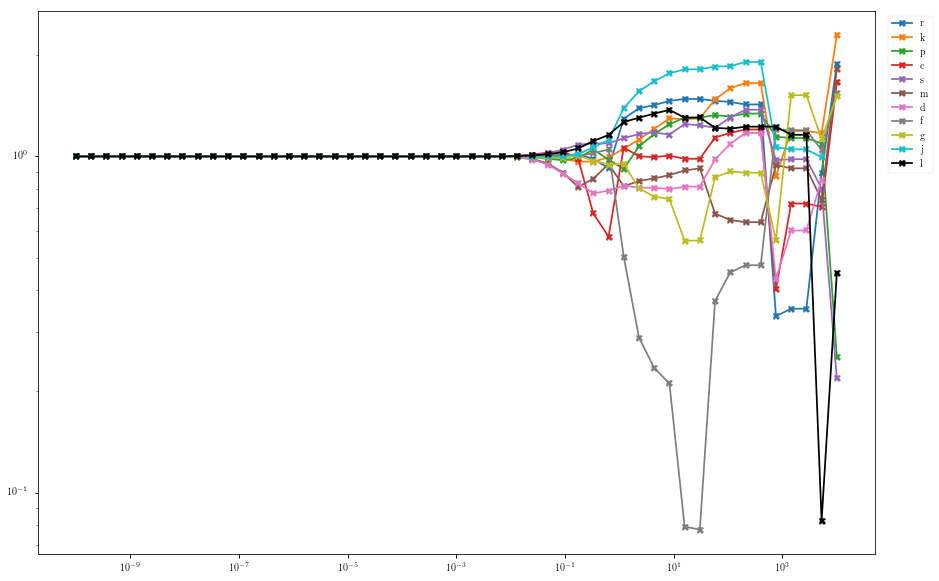

In [11]:
rhos = [float(rho) for rho in solver.solutions.keys()]
vals = [val[0].x for val in solver.solutions.values()]
plt.plot(rhos, vals, 'X-')
plt.legend("rkpcsmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

Text(0, 0.5, 'Number')

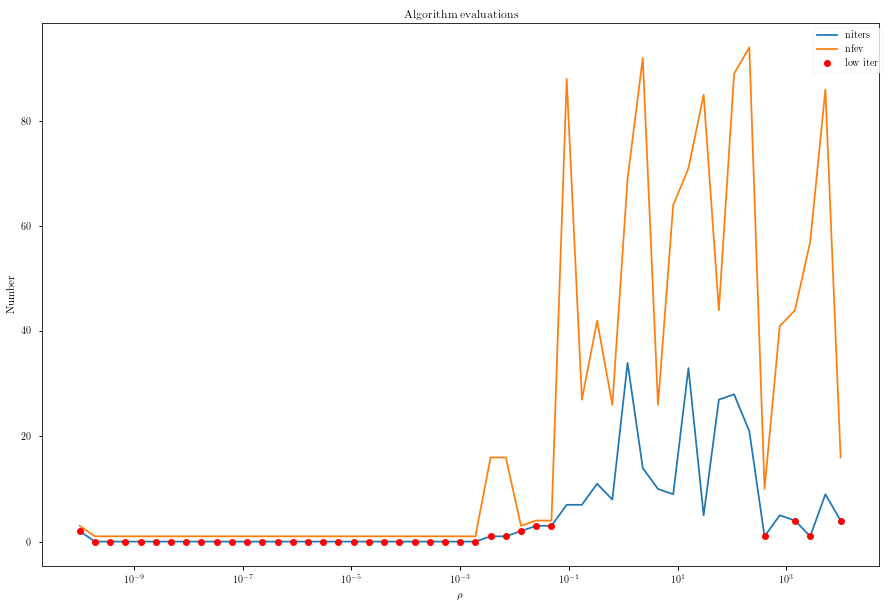

In [12]:
iters_list = np.array([[float(key), value[0].nit] for key, value in solver.solutions.items()])
fevs_list = np.array([[float(key), value[0].nfev] for key, value in solver.solutions.items()])
plt.semilogx(*iters_list.T, *fevs_list.T)

low_iters = np.array([[k,v] for k,v in iters_list if v < 5])
plt.plot(*low_iters.T, 'ro')

plt.legend(["niters", "nfev", "low iter"], 
           loc="best", bbox_to_anchor=(1.01, 1))
plt.title("Algorithm evaluations")
plt.xlabel(r"$\rho$")
plt.ylabel("Number")

In [13]:
def tokey(rho, ps):
    return f"{'y'.join(map(str,ps))}r{rho}"
getx = fitter.ca.Function("getx", [model.ts, *model.cs], model.xs)
    

[1.46227618 1.29659646 1.24613031 1.0056145  1.16158435 0.87980832
 0.79911881 0.21114683 0.74618413 1.76788324 1.37548563]
[[ 0.001589    0.09614088 -0.73678543]]


Text(0.5, 0, 'time, t')

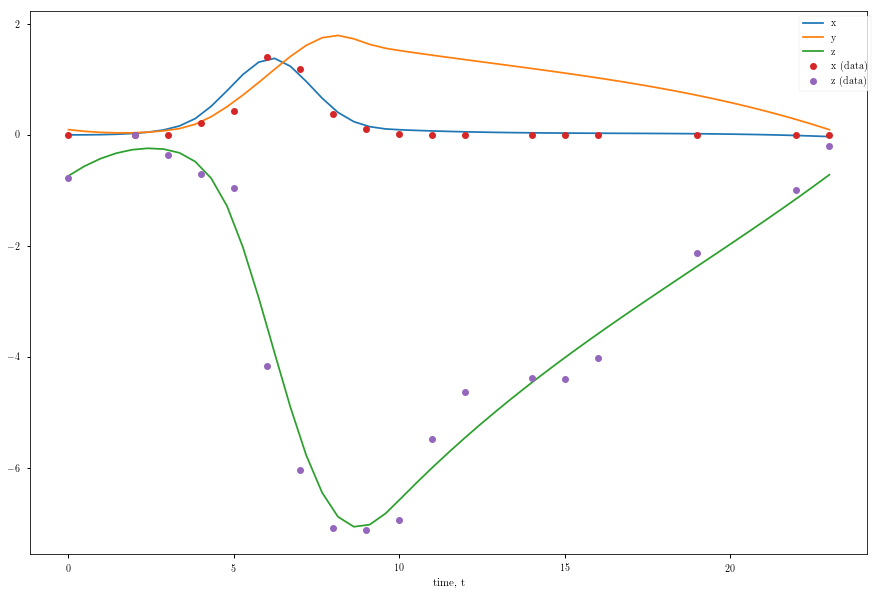

In [14]:
target_rho = 8.317637711026743
c_end = solver.problems[0].cache.results[tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x
print(solver.solutions[str(target_rho)][0].x)
xs_end = np.array([np.array(i) for i in getx(model.observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])
print(xs_end[:,0].T)
plt.plot(model.observation_times, np.hstack([xs_end[0], xs_end[1], xs_end[2]]),
         context.datasets[0]['t'], context.datasets[0]['x'], 'o',
         context.datasets[0]['t'], context.datasets[0]['z'], 'o')
plt.legend(list("xyz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

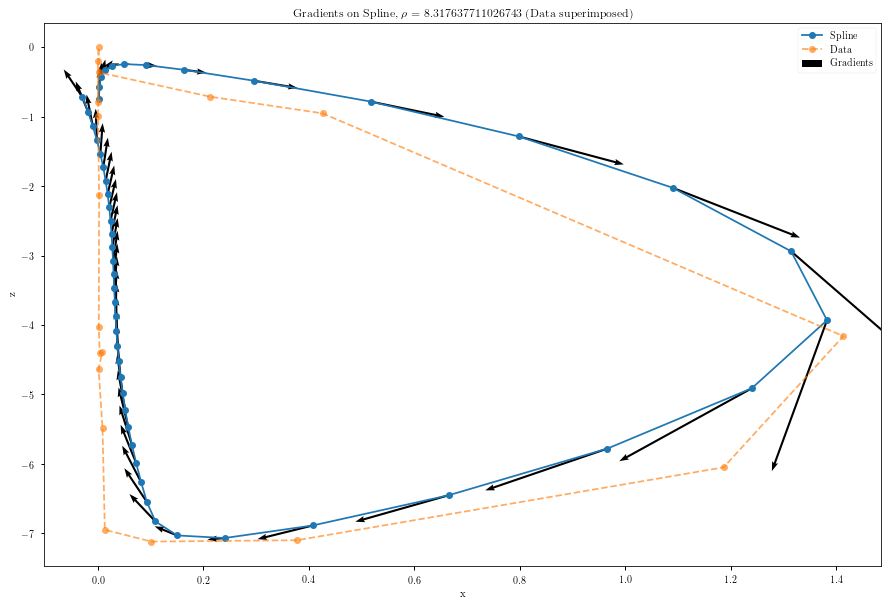

In [15]:
spline_dfield = np.array([context.model(t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(model.observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.plot(xs_end[0], xs_end[2], 'o-')
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])

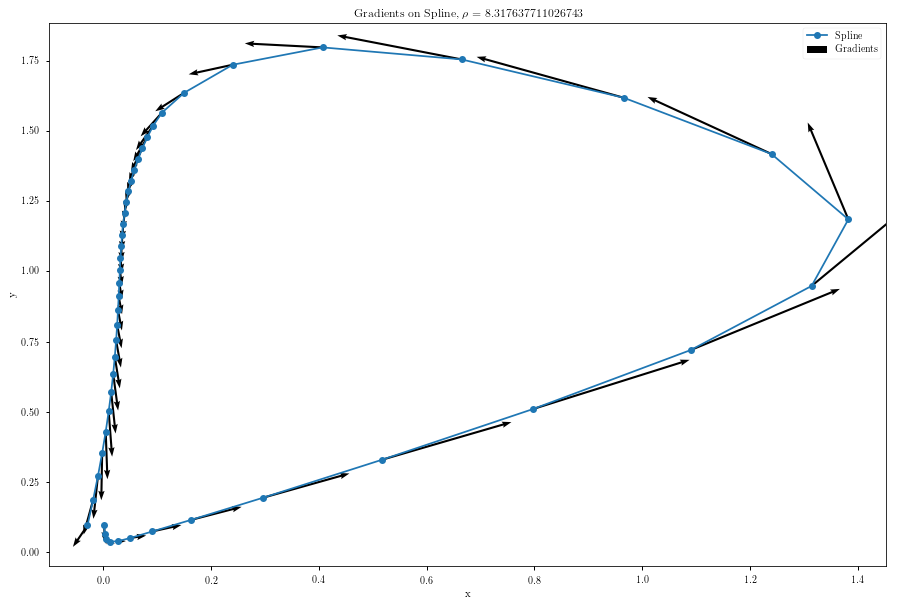

In [16]:
plt.plot(xs_end[0], xs_end[1], 'o-')
plt.quiver(xs_end[0], xs_end[1], spline_dfield[:,0], spline_dfield[:,1], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Spline", "Gradients"])

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

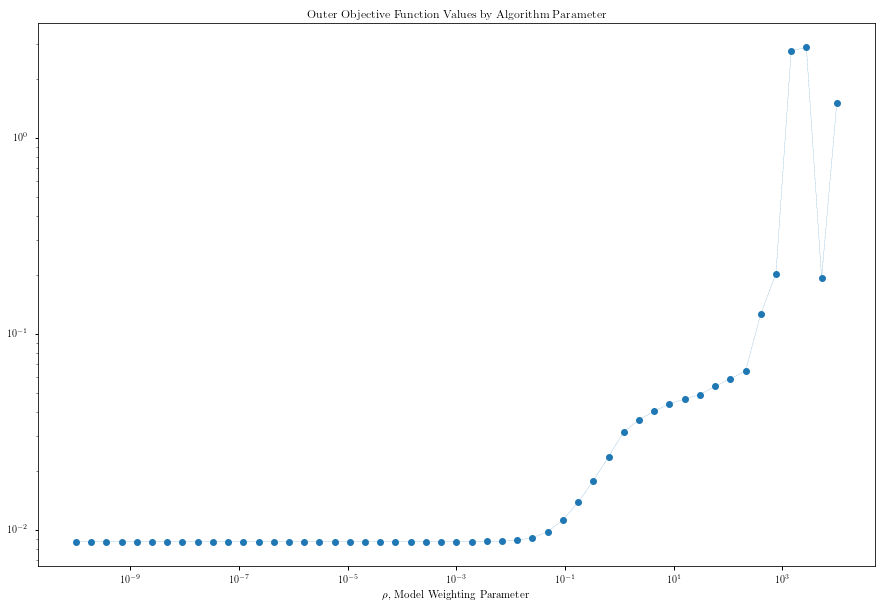

In [17]:
outer_objective_values = np.array([[float(rho), val[0].fun] for rho, val in solver.solutions.items()])
plt.loglog(*outer_objective_values.T, 'o--', linewidth=0.25)
plt.title("Outer Objective Function Values by Algorithm Parameter")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

In [18]:
inner_objective_values = np.array([[r, solver.problems[0].cache.results[tokey(r, v)].fun] for r,v in zip(rhos, vals)])
dfield = np.abs(np.hstack([np.array(rhos).reshape(-1,1), 
                           ((inner_objective_values - outer_objective_values)[:,1] / rhos).reshape(-1,1)]))


Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

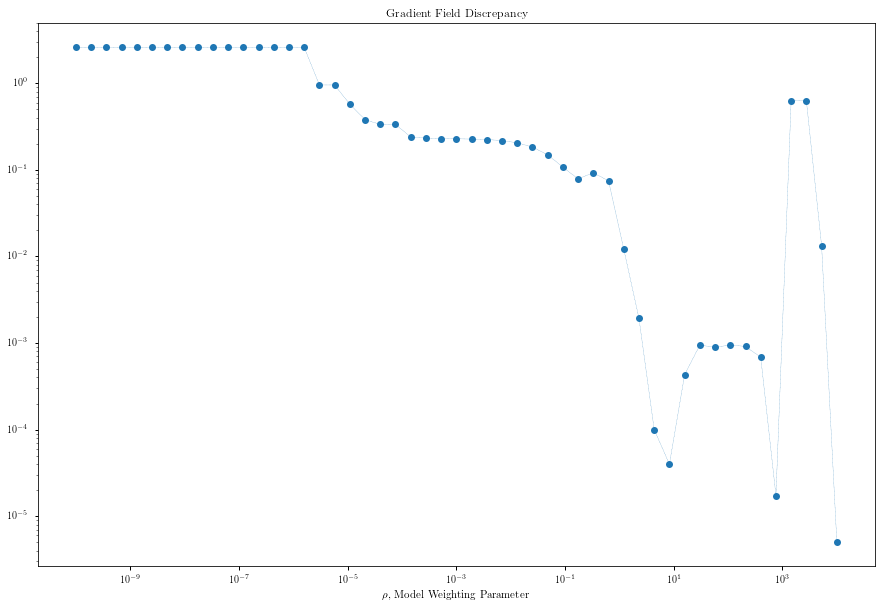

In [19]:
plt.loglog(*dfield.T, 'o--', linewidth=0.25)
plt.title("Gradient Field Discrepancy")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

Text(0, 0.5, 'Diff Field')

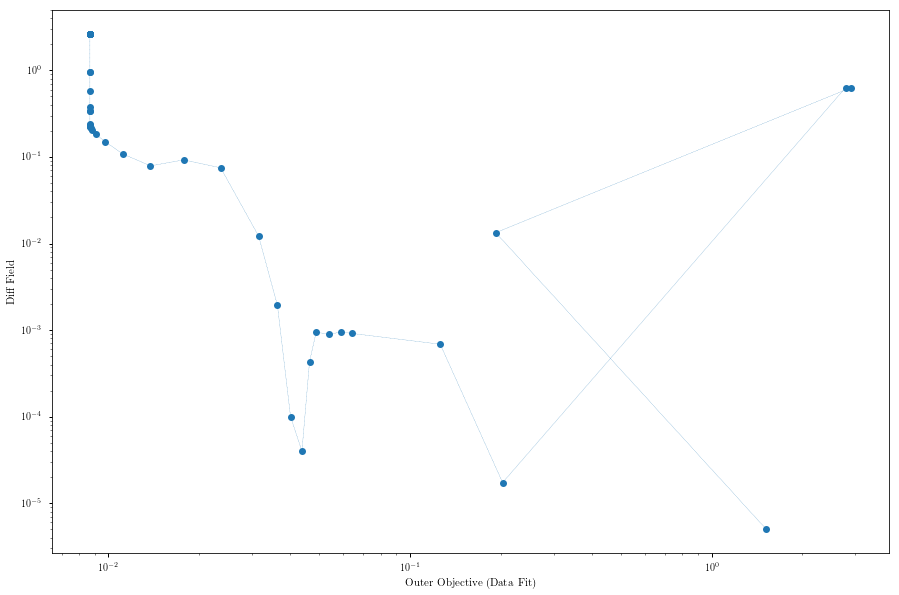

In [20]:
plt.loglog(outer_objective_values[:,1], dfield[:,1], '--o', linewidth=0.25)
plt.xlabel("Outer Objective (Data Fit)")
plt.ylabel("Diff Field")

Text(0, 0.5, '$\\kappa$')

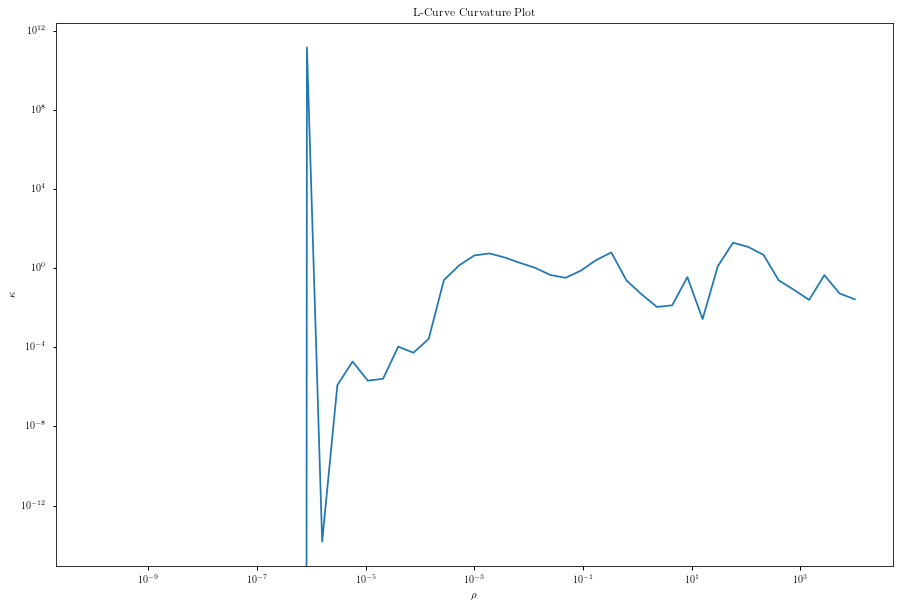

In [48]:
curv_dx = np.gradient(np.log(outer_objective_values[:,1]))
curv_dy = np.gradient(np.log(dfield[:,1]))
curv_dx2 = np.gradient(curv_dx)
curv_dy2 = np.gradient(curv_dy)

kappa = np.abs(curv_dx*curv_dy2 - curv_dy*curv_dx2)/(curv_dx**2 + curv_dy**2)**(3/2)

plt.loglog(rhos, kappa)
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\kappa$")

## Odd Validation

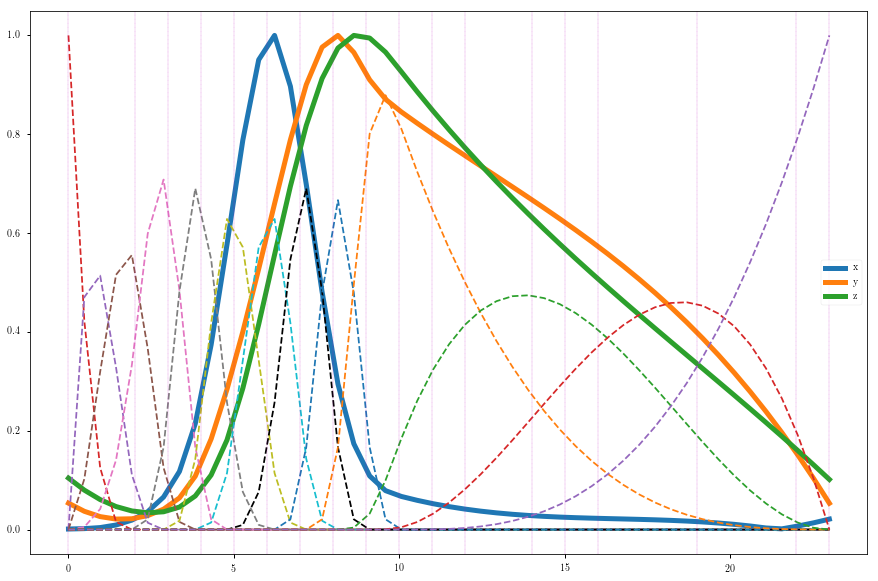

In [22]:
bfn = modeller.ca.Function('basis_fns', [model.ts], [model.basis])
plt.plot(model.observation_times, np.abs(np.hstack([xs_end[0]/max(abs(xs_end[0])), 
                                             xs_end[1]/max(abs(xs_end[1])), 
                                             xs_end[2]/max(abs(xs_end[2]))])),
         linewidth=5)
plt.plot(model.observation_times, bfn(model.observation_times), '--')
plt.legend('xyz')
[plt.axvline(x=i, color='m', linewidth=0.25, linestyle='--') for i in context.datasets[0]['t']]
print("")

In [23]:
# generate a crude correlation plot

import pandas as pd

results = pd.DataFrame({r"$\rho$": np.log(rhos)})
for idx, name in enumerate("rkpcsmdfgjl"):
    results[name] = [v[idx] for v in vals]
    

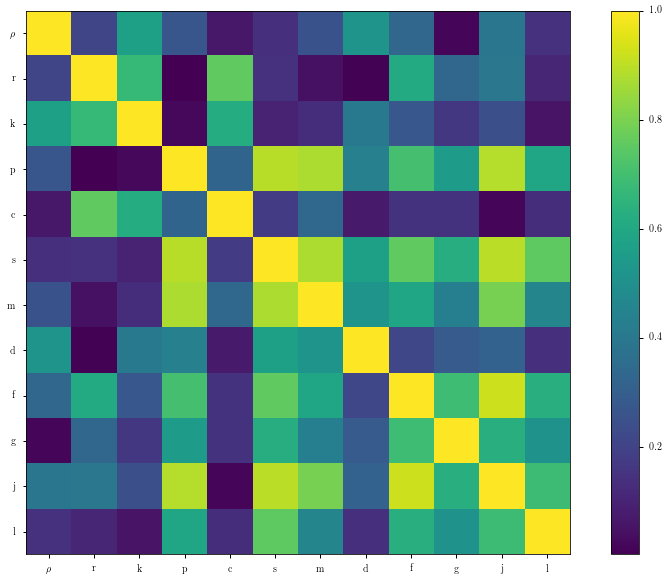

In [24]:
plt.imshow(np.abs(results.corr()))
plt.colorbar()
plt.xticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.yticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.grid(False)

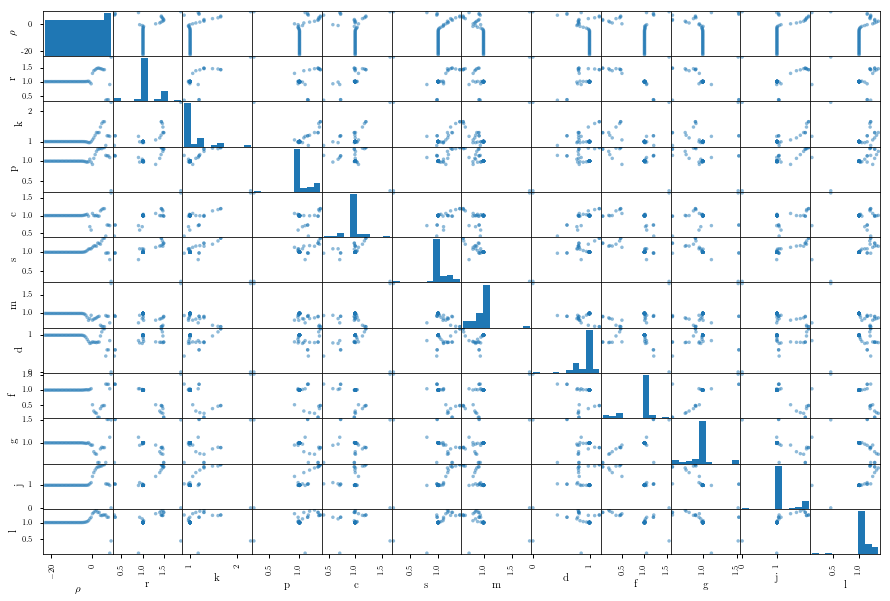

In [25]:
ax = pd.plotting.scatter_matrix(results)
for a in ax.flatten():
    a.grid(False)

## Smoothing Experiments

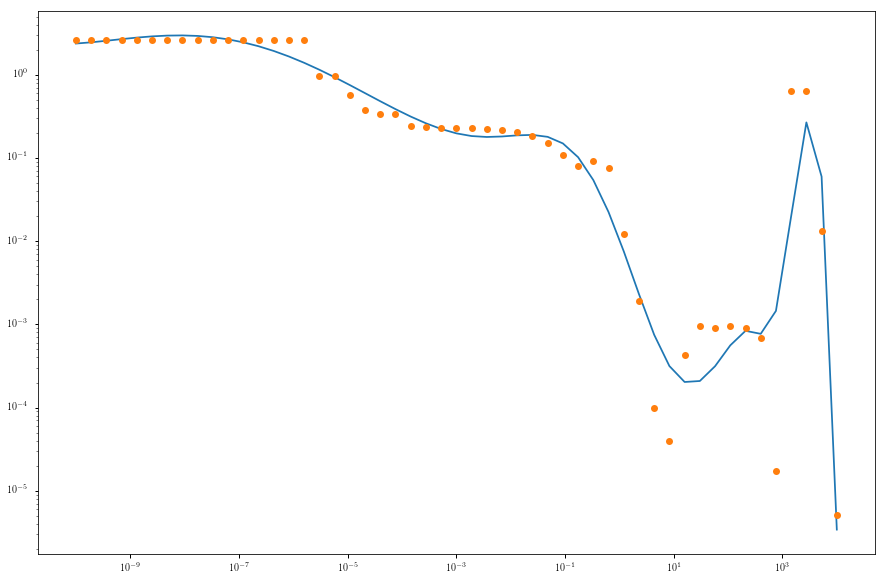

In [39]:
from scipy import interpolate

smooth_dfield = interpolate.UnivariateSpline(np.log(rhos), np.log(dfield[:,1]), s=None, k=4)

sfield =  np.exp(smooth_dfield(np.log(rhos)))

plt.loglog(rhos, sfield, rhos, dfield[:,1], 'o')

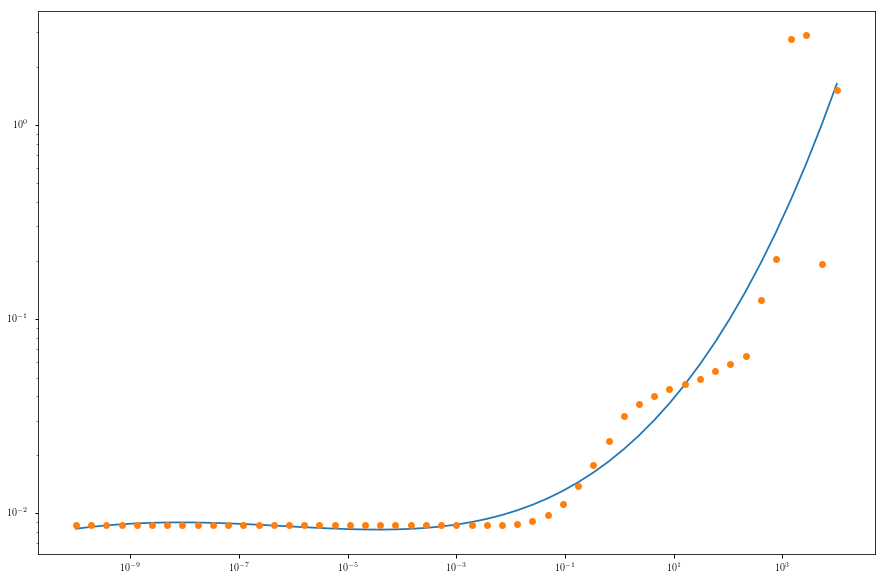

In [40]:
smooth_outer = interpolate.UnivariateSpline(np.log(rhos), np.log(outer_objective_values[:,1]), s=None, k=4)
souter = np.exp(smooth_outer(np.log(rhos)))
plt.loglog(rhos, souter, rhos, outer_objective_values[:,1], 'o')

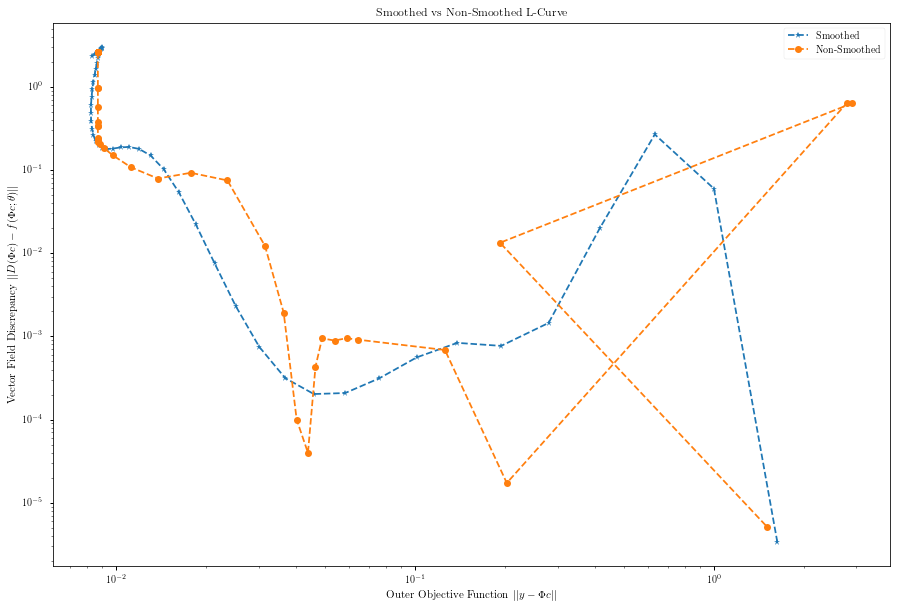

In [41]:
plt.loglog(souter, sfield, '*--', outer_objective_values[:,1], dfield[:,1], 'o--')
plt.title("Smoothed vs Non-Smoothed L-Curve")
plt.xlabel(r"Outer Objective Function $||y-{\Phi}c||$")
plt.ylabel(r"Vector Field Discrepancy $||D({\Phi}c) - f({\Phi}c; \theta)||$")
plt.legend(["Smoothed", "Non-Smoothed"])

Text(0, 0.5, '$\\kappa$')

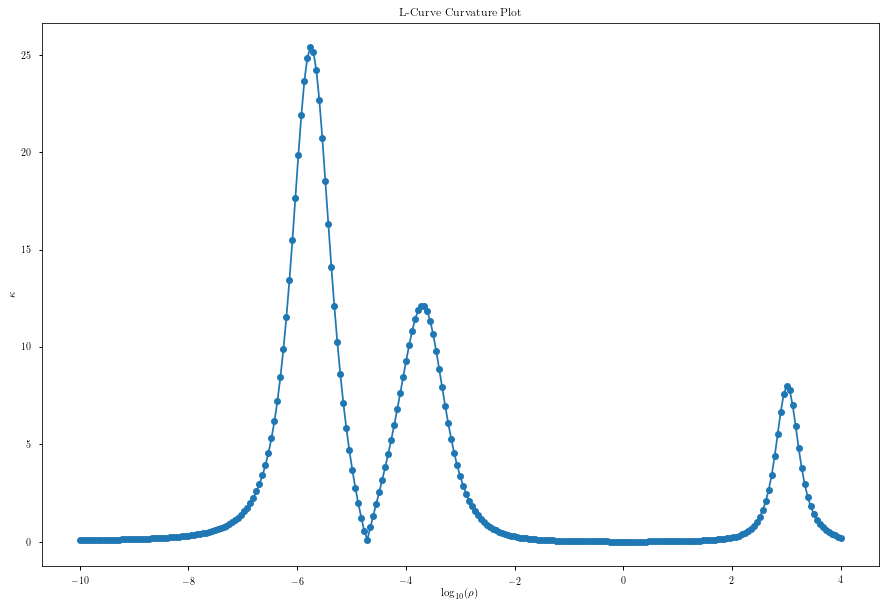

In [42]:
# ? curvature
f_dx = smooth_outer.derivative(1)
f_dy = smooth_dfield.derivative(1)
f_dx2 = smooth_outer.derivative(2)
f_dy2 = smooth_dfield.derivative(2)

rhos_log_finer = np.linspace(np.log10(rhos[0]), np.log10(rhos[-1]), len(rhos)*5)

scurv_dx = f_dx(rhos_log_finer)
scurv_dy = f_dy(rhos_log_finer)
scurv_dx2 = f_dx2(rhos_log_finer)
scurv_dy2 = f_dy2(rhos_log_finer)

kappa_fine = np.abs(scurv_dx*scurv_dy2 - scurv_dy*scurv_dx2)/(scurv_dx**2 + scurv_dy**2)**(3/2)

plt.plot(rhos_log_finer, kappa_fine, 'o-')
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

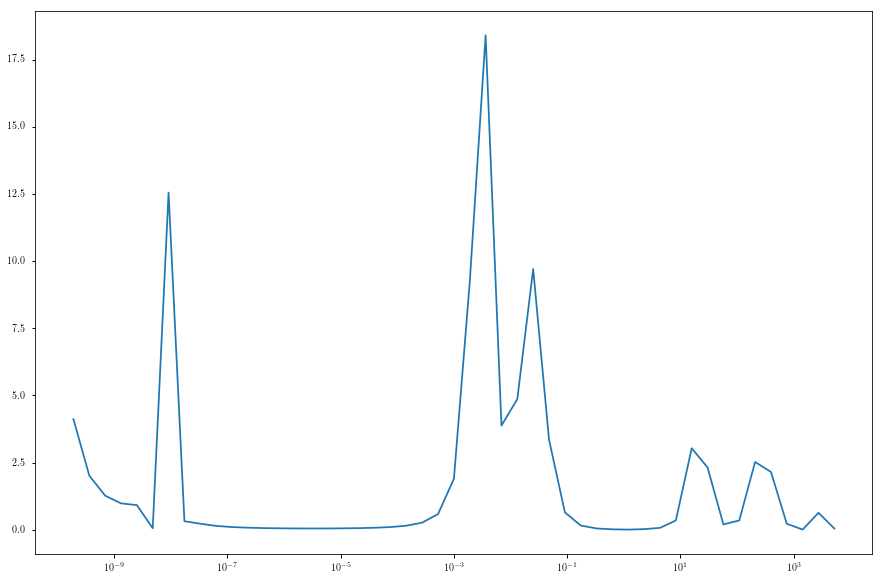

In [46]:
# menger curvature
curvs = []
for idx in range(1, len(rhos)-1):
    xs = np.log(souter[idx-1:idx+2])
    ys = np.log(sfield[idx-1:idx+2])
    ps = np.vstack([xs,ys]).T
    curvs.append(2*np.abs(np.cross(ps[1] - ps[0], ps[2]-ps[1]))/(
            np.linalg.norm(ps[0]-ps[1])*np.linalg.norm(ps[1]-ps[2])*np.linalg.norm(ps[2]-ps[0])))

plt.semilogx(rhos[1:-1], np.array(curvs))

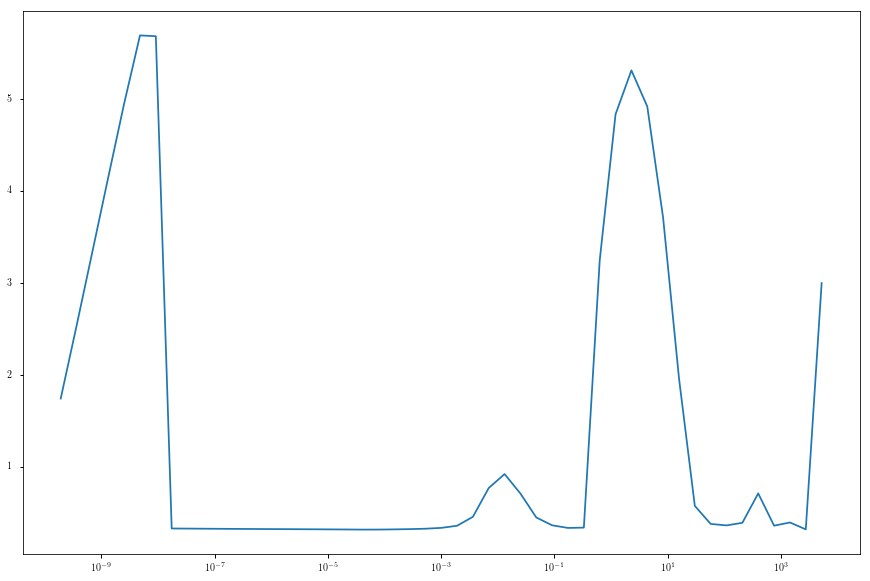

In [47]:
# straight up cosines

xkm1 = np.log(souter[0:-2]) - np.log(souter[1:-1])
xkp1 = np.log(souter[2:]) - np.log(souter[1:-1])
ykm1 = np.log(sfield[0:-2]) - np.log(sfield[1:-1])
ykp1 = np.log(sfield[2:]) - np.log(souter[1:-1])
angles = np.arccos((xkm1*xkp1 - ykp1*ykm1) / (np.sqrt(xkm1**2 + ykm1**2)*np.sqrt(xkp1**2 + ykp1**2)))
plt.semilogx(rhos[1:-1], 1/angles)

In [32]:
solver._inner_objective.weightings


array([0.70733767, 0.14044944])

In [33]:
rhos

[1e-10,
 1.9054607179632444e-10,
 3.6307805477010177e-10,
 6.918309709189363e-10,
 1.31825673855641e-09,
 2.511886431509582e-09,
 4.78630092322638e-09,
 9.120108393559115e-09,
 1.7378008287493763e-08,
 3.3113112148259144e-08,
 6.309573444801943e-08,
 1.2022644346174132e-07,
 2.2908676527677748e-07,
 4.365158322401665e-07,
 8.317637711026709e-07,
 1.584893192461114e-06,
 3.0199517204020193e-06,
 5.754399373371579e-06,
 1.0964781961431874e-05,
 2.089296130854041e-05,
 3.9810717055349776e-05,
 7.585775750291851e-05,
 0.0001445439770745928,
 0.0002754228703338169,
 0.0005248074602497734,
 0.001000000000000002,
 0.001905460717963252,
 0.0036307805477010175,
 0.006918309709189377,
 0.0131825673855641,
 0.025118864315095822,
 0.047863009232264,
 0.09120108393559115,
 0.17378008287493762,
 0.3311311214825921,
 0.6309573444801942,
 1.202264434617418,
 2.2908676527677794,
 4.3651583224016655,
 8.317637711026743,
 15.848931924611174,
 30.199517204020193,
 57.5439937337159,
 109.64781961431873,
 2